In [9]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.7M Feb 12 11:01 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  21M Feb 12 10:59 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  14M Feb 12 10:59 data/Mir.csv.bz2


In [3]:
name_dataset = 'Byvsij_SSSR'

### load data

In [88]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(44924, 4)
CPU times: user 4.23 s, sys: 461 ms, total: 4.69 s
Wall time: 3.92 s


In [89]:
df.head()

,date,topic,text,predict
0,2008-02-11 12:55:00,"""Экономика""","['премьерминистр', 'украина', 'юлий', 'тимошен...",Бывший СССР
1,2008-02-11 18:27:00,"""В России""","['ключевой', 'вопрос', 'визит', 'украина', 'ви...",Бывший СССР
2,2008-02-11 23:05:00,"""В России""","['парламентский', 'большинство', 'намерить', '...",Бывший СССР
3,2008-02-13 10:20:00,"""В России""","['известный', 'грузинский', 'бизнесмен', 'бадр...",Бывший СССР
4,2008-02-13 14:01:00,"""В мире""","['аркадий', 'бадри', 'патаркацишвили', 'родить...",Бывший СССР


* parse data

In [90]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,year,month
0,2008-02-11 12:55:00,"""Экономика""","['премьерминистр', 'украина', 'юлий', 'тимошен...",Бывший СССР,2008,2
1,2008-02-11 18:27:00,"""В России""","['ключевой', 'вопрос', 'визит', 'украина', 'ви...",Бывший СССР,2008,2
2,2008-02-11 23:05:00,"""В России""","['парламентский', 'большинство', 'намерить', '...",Бывший СССР,2008,2
3,2008-02-13 10:20:00,"""В России""","['известный', 'грузинский', 'бизнесмен', 'бадр...",Бывший СССР,2008,2
4,2008-02-13 14:01:00,"""В мире""","['аркадий', 'бадри', 'патаркацишвили', 'родить...",Бывший СССР,2008,2


In [91]:
df.year.value_counts()

2015    7525
2014    7517
2008    4994
2009    4559
2016    4246
2010    3771
2017    3311
2018    3143
2011    2093
2013    1882
2012    1750
2019     133
Name: year, dtype: int64

In [92]:
df.month.value_counts()

4     4579
2     4160
5     4100
8     3983
7     3820
3     3784
6     3689
10    3552
9     3386
12    3364
1     3313
11    3194
Name: month, dtype: int64

In [93]:
df.text = df.text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

In [94]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 12:55:00,"""Экономика""","[премьерминистр, украина, юлий, тимошенко, зая...",Бывший СССР,2008,2,премьерминистр украина юлий тимошенко заявлять...
1,2008-02-11 18:27:00,"""В России""","[ключевой, вопрос, визит, украина, виктор, юще...",Бывший СССР,2008,2,ключевой вопрос визит украина виктор ющенко рф...
2,2008-02-11 23:05:00,"""В России""","[парламентский, большинство, намерить, разблок...",Бывший СССР,2008,2,парламентский большинство намерить разблокиров...
3,2008-02-13 10:20:00,"""В России""","[известный, грузинский, бизнесмен, бадри, пата...",Бывший СССР,2008,2,известный грузинский бизнесмен бадри патаркаци...
4,2008-02-13 14:01:00,"""В мире""","[аркадий, бадри, патаркацишвили, родиться, тби...",Бывший СССР,2008,2,аркадий бадри патаркацишвили родиться тбилиси ...


* cleanedNames

In [95]:
from cleanedNames import KeyProc
cn = KeyProc()

In [96]:
%%time
df.text_join = df.text_join.apply(cn.replaceKeywords)

CPU times: user 56 s, sys: 5.59 s, total: 1min 1s
Wall time: 51.8 s


In [97]:
df.text = df.text_join.apply(lambda x: x.split(' ')) 
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 12:55:00,"""Экономика""","[премьерминистр, украина, юлий, тимошенко, зая...",Бывший СССР,2008,2,премьерминистр украина юлий тимошенко заявлять...
1,2008-02-11 18:27:00,"""В России""","[ключевой, вопрос, визит, украина, виктор_ющен...",Бывший СССР,2008,2,ключевой вопрос визит украина виктор_ющенко рф...
2,2008-02-11 23:05:00,"""В России""","[парламентский, большинство, намерить, разблок...",Бывший СССР,2008,2,парламентский большинство намерить разблокиров...
3,2008-02-13 10:20:00,"""В России""","[известный, грузинский, бизнесмен, бадри_патар...",Бывший СССР,2008,2,известный грузинский бизнесмен бадри_патаркаци...
4,2008-02-13 14:01:00,"""В мире""","[аркадий, бадри_патаркацишвили, родиться, тбил...",Бывший СССР,2008,2,аркадий бадри_патаркацишвили родиться тбилиси ...


* add docID

In [98]:
df['docID'] = list(range(df.shape[0]))

In [99]:
df.rename(columns={'text':'lemmatized_text'},inplace=True)

In [100]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[премьерминистр, украина, юлий, тимошенко, зая..."
1,1,2008,2,"[ключевой, вопрос, визит, украина, виктор_ющен..."


In [101]:
print(df.shape)
df.isnull().sum()

(44924, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [102]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [103]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 441 ms, sys: 111 ms, total: 552 ms
Wall time: 477 ms


In [104]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [105]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Byvsij_SSSR", num_batches=45)
CPU times: user 14.9 s, sys: 747 ms, total: 15.6 s
Wall time: 2.77 s


In [106]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [107]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=da2f435f-90e6-482a-a404-0502887327ac, num_entries=18075)

In [108]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [109]:
select_topics = 20

In [110]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6864070296287537
	SparsityPhiScore: 0.8753250241279602
	PerplexityScore: 1987.37890625


In [111]:
best_model = model.clone()
best_model.num_topics

20

---

### print top words for each topics

In [112]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['миллион' 'газа' 'миллиард' 'предприятие' 'поставка' 'средство' 'цена'
 'сумма' 'электроэнергия' 'строительство']
topic_1: ['тимошенко' 'янукович' 'виктор_янукович' 'юлий' 'интерфаксукраина'
 'оппозиция' 'заседание' 'батькивщина' 'премьерминистр' 'юлия_тимошенко']
topic_2: ['обстрел' 'огонь' 'азербайджан' 'позиция' 'пункт' 'мм' 'направление'
 'населить' 'миномёт' 'оружие']
topic_3: ['оборона' 'военнослужащий' 'войско' 'нато' 'учение' 'база' 'минобороны'
 'подразделение' 'зона' 'техника']
topic_4: ['киргизия' 'бишкек' 'временной' 'снг' 'бакиев' 'киргизский' 'случай' 'юг'
 'опрос' 'население']
topic_5: ['абхазия' 'армения' 'ереван' 'абхазский' 'армянский' 'премьерминистр'
 'отставка' 'член' 'пост' 'грузинский']
topic_6: ['белоруссия' 'гуманитарный' 'белорусский' 'минск' 'помощь' 'груз' 'мчс'
 'лукашенко' 'колонна' 'пропуск']
topic_7: ['взрыв' 'погибнуть' 'пострадавший' 'погибший' 'дом' 'больница'
 'пострадать' 'пожар' 'состояние' 'ребёнок']
topic_8: ['выбор' 'верховный' 'закон'

### get topics-docs matrix

shape theta: (20, 44924)


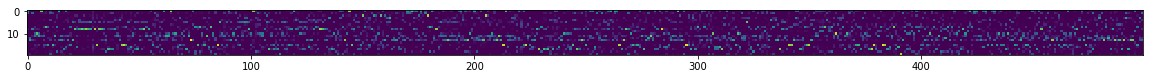

In [113]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [114]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
41000,0.010694,0.058716,0.0,0.000000,0.347363,0.0,0.000000,0.000000,0.573651,0.00000,0.0,0.000000,0.000000,0.009576,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
41001,0.000000,0.244425,0.0,0.000000,0.000000,0.0,0.000000,0.029383,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.388008,0.187138,0.000000,0.000000,0.151046
41002,0.000000,0.000000,0.0,0.082652,0.000000,0.0,0.000000,0.297964,0.000000,0.32793,0.0,0.000000,0.000000,0.000000,0.0,0.237385,0.054069,0.000000,0.000000,0.000000
41003,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.034611,0.037785,0.000000,0.00000,0.0,0.016814,0.000000,0.000000,0.0,0.000000,0.068617,0.828406,0.000000,0.013768
41004,0.250618,0.047301,0.0,0.164979,0.000000,0.0,0.000000,0.000000,0.034230,0.00000,0.0,0.000000,0.218938,0.000000,0.0,0.000000,0.000000,0.000000,0.283934,0.000000


## DataViz

In [115]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.519572,0.405352,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.030625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2008,2,0.033068,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.338184,0.569368,0.0,0.000000,0.000000,0.000000,0.000000,0.059380
2,2,2008,2,0.000000,0.301418,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.067513,0.000000,0.159203,0.0,0.000000,0.000000,0.038538,0.000000,0.000000
3,3,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.245113,0.343213,0.000000,0.078473,0.0,0.096704,0.034807,0.021621,0.000000,0.012089
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.679660,0.146209,0.000000,0.000000,0.0,0.047316,0.022219,0.000000,0.018469,0.000000


In [116]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 20)


topic_0    topic_1   topic_2    topic_3    topic_4    topic_5  \
year month                                                                    
2008 2       5.838182   3.734503  1.097257   2.267316   2.385306   8.561080   
     3      25.404516  11.987864  8.760561  10.875925  10.579148  13.373359   
     4      16.606512  13.247094  3.453729  19.868088   7.948467  19.145876   
     5      13.352858  11.554200  4.728561  33.571854   9.428657  23.967989   
     6      13.571748  12.421545  4.405662  19.220165   6.373638  14.387038   

             topic_6    topic_7    topic_8   topic_9   topic_10   topic_11  \
year month                                                                   
2008 2      1.094172   6.542065  13.785897  0.994456   8.012558  13.406316   
     3      6.994673  20.825802  25.839096  7.953357  22.600246  34.609940   
     4      5.710406  17.468575  20.011925  9.514665  14.722031  39.479385   
     5      9.028077  32.014317  29.237438  9.817869  12.447556  50.270226   
     6      9.005835  41.015163  13.530711  6.729119  13.870145  36.174065   

             topic_12   topic_13  topic_14   topic_15   topic_16   topic_17  \
year month                                                                    
2008 2       1.491383   9.750027  0.463645  10.999711   4.202811   6.079492   
     3      17.510969  46.690697  1.737918  34.465317  15.686100  29.755877   
     4      11.281208  47.593861  1.991424  38.498680  18.892958  18.230680   
     5      12.144541  51.902195  3.208129  41.891251  22.754627  21.076851   
     6      12.551292  42.998917  1.475783  38.989090  20.001785  11.605062   

             topic_18  topic_19  
year month                       
2008 2       3.317644  1.976181  
     3       9.928105  7.420531  
     4       8.812634  8.521808  
     5      15.662666  7.940143  
     6       8.167574  7.505667

### straightforward matrix heatmap

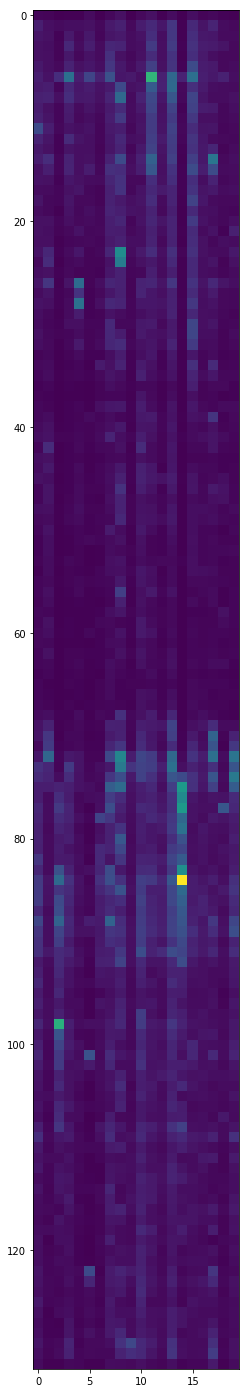

In [132]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [118]:
import pygal
from IPython.display import SVG, HTML

In [119]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [120]:
max(gb['topic_1'].values)

97.47124

In [121]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [122]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [123]:
import joypy # !pip install joypy

In [124]:
print(joined.shape)
joined.head()

(44924, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.519572,0.405352,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.030625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2008,2,0.033068,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.338184,0.569368,0.0,0.000000,0.000000,0.000000,0.000000,0.059380
2,2,2008,2,0.000000,0.301418,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.067513,0.000000,0.159203,0.0,0.000000,0.000000,0.038538,0.000000,0.000000
3,3,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.245113,0.343213,0.000000,0.078473,0.0,0.096704,0.034807,0.021621,0.000000,0.012089
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.679660,0.146209,0.000000,0.000000,0.0,0.047316,0.022219,0.000000,0.018469,0.000000


In [125]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,2008,2,0.519572,0.405352,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.030625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
1,1,2008,2,0.033068,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.338184,0.569368,0.0,0.000000,0.000000,0.000000,0.000000,0.059380,2008-02-01
2,2,2008,2,0.000000,0.301418,0.0,0.0,0.0,0.0,0.0,...,0.067513,0.000000,0.159203,0.0,0.000000,0.000000,0.038538,0.000000,0.000000,2008-02-01
3,3,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.343213,0.000000,0.078473,0.0,0.096704,0.034807,0.021621,0.000000,0.012089,2008-02-01
4,4,2008,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.146209,0.000000,0.000000,0.0,0.047316,0.022219,0.000000,0.018469,0.000000,2008-02-01


In [126]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.519572
1,2008-02-01,topic_0,0.033068
6,2008-02-01,topic_0,0.743129
7,2008-02-01,topic_0,0.002774
8,2008-02-01,topic_0,0.047450


In [127]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic              
2008-02-01 topic_0    5.838182
           topic_1    3.734503
           topic_10   8.012558
           topic_11  13.406316
           topic_12   1.491383

In [128]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,5.838182
1,2008-02-01,topic_1,3.734503
2,2008-02-01,topic_10,8.012558
3,2008-02-01,topic_11,13.406316
4,2008-02-01,topic_12,1.491383


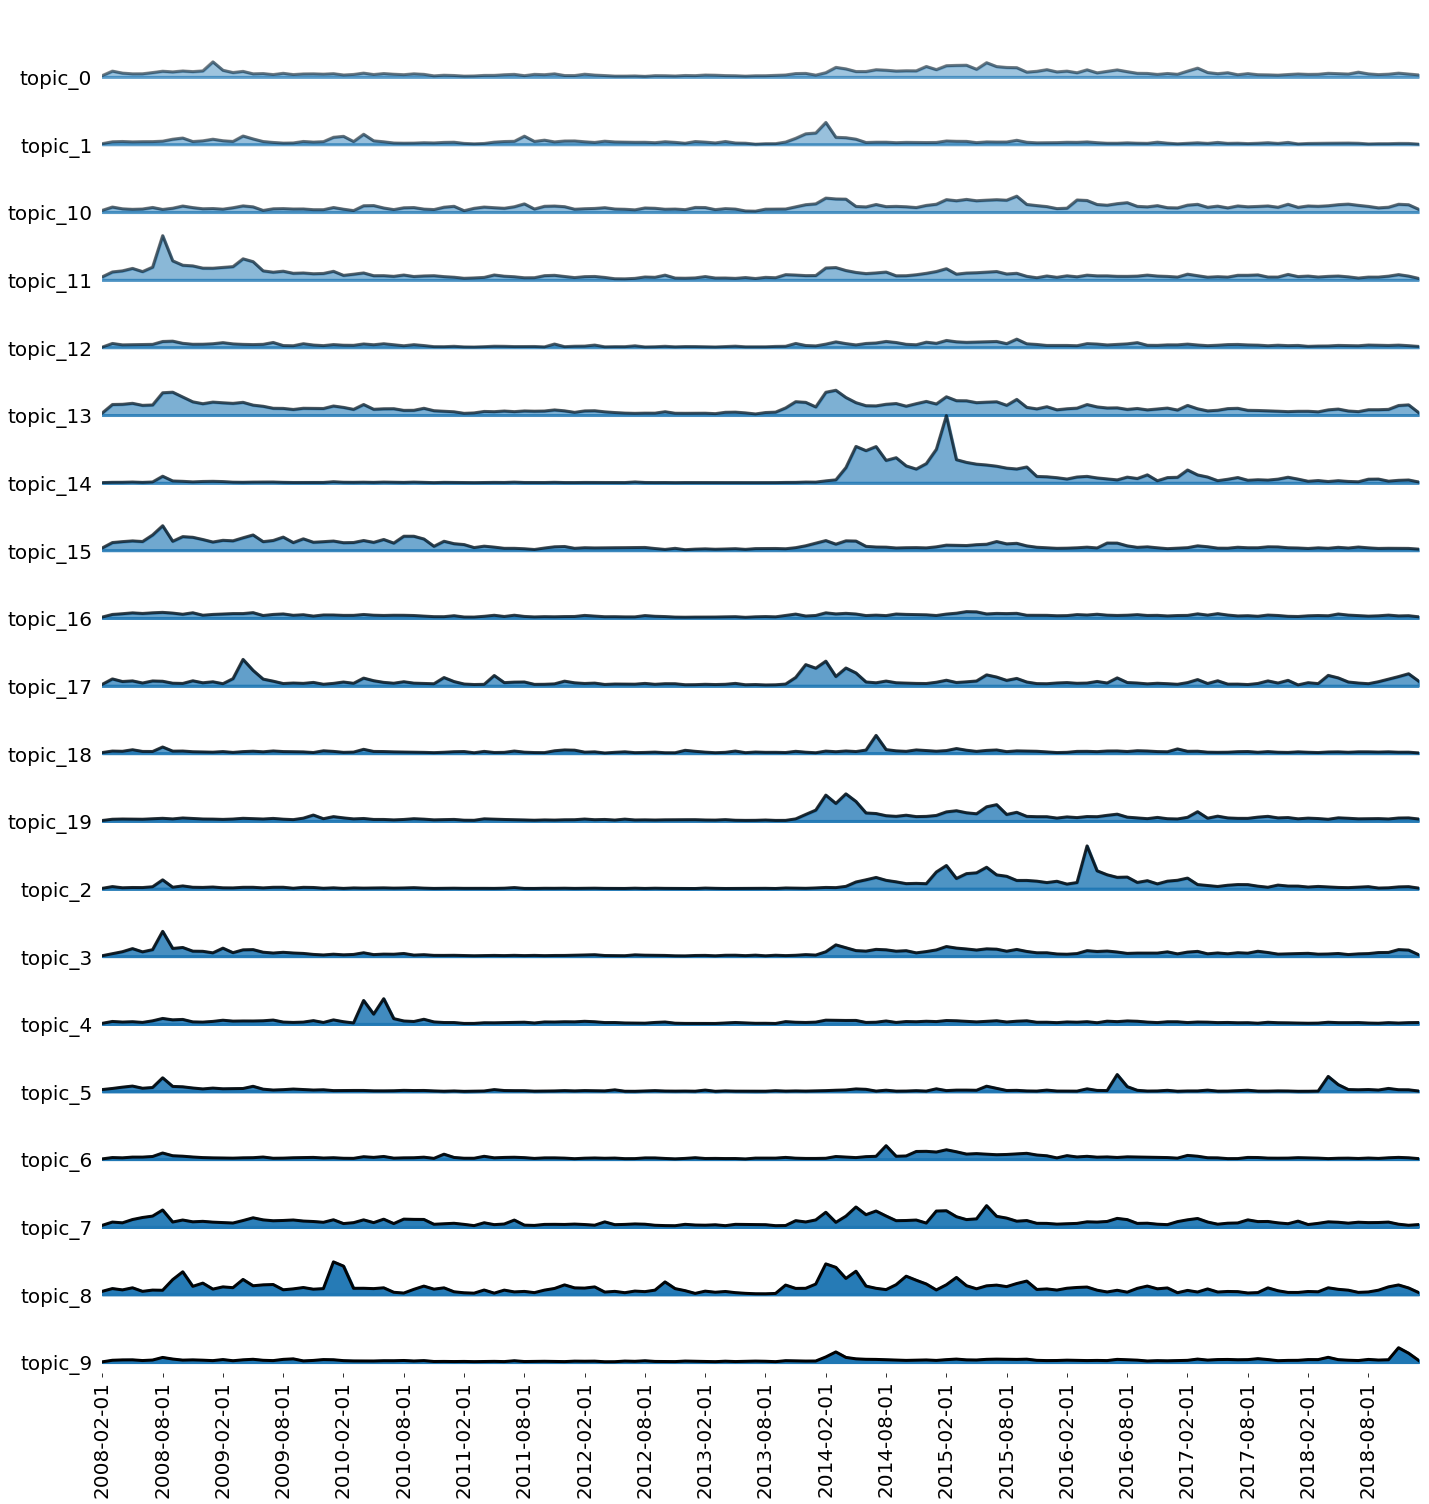

In [129]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [130]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")